Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-autoencoder.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-autoencoder.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel simple de type autoencodeur.

Cet exemple est censé être lu après avoir lu l'exemple "mnist", dont il est directement dérivé. Seuls les parties différentes sont commentées.

<br>
<br>
<br>
Imports des librairies, paramètres généraux et définition du jeu de données. Cette partie est quasi inchangée, seul le paramètre num_classes est supprimé ici, car on ne se trouve plus dans un problème de classification (les classes ne joueront aucun rôle). Il est remplacé par dim_code, la dimension de l'espace des codes, qui est fixée arbitrairement.

In [ ]:
%matplotlib inline

#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
dim_code = 30
batch_size = 100
learning_rate = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

tensor([5, 0, 4, 1, 9])


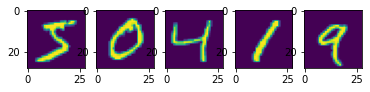

In [ ]:
labels = train_dataset.targets
print(labels[0:5])
images = train_dataset.data.float()/255
import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images[k,:,:])
plt.show()

<br>
<br>
<br>
Définition du réseau. On le sépare en deux parties, encodeur et décodeur. L'encodeur regroupe en fait les deux premières couches de l'exemple "mnist", tandis que le décodeur est constitué également de deux couches similaires, mais où les opérations de convolutions sont remplacées par des "transposées de convolution", ce qui est très proche mais permet d'augmenter la dimension des couches.

In [ ]:

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self,dim_code):
        super(ConvNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fce = nn.Linear(7*7*32, dim_code)
        self.fcd = nn.Linear(dim_code, 7*7*32)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        # encoding
        out = self.encoder(x)
        sz = out.size()
        out = out.reshape(out.size(0), -1)
        out = self.fce(out)
        # decoding
        out = self.fcd(out)
        out = out.reshape(sz)
        out = self.decoder(out)
        return out

model = ConvNet(dim_code).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Entraînement du réseau. Ici la seule mais fondamentale différence est que la fonction coût évalue la différence
entre la sortie du réseau et les images d''entrée, et non plus entre la sortie et les classes.
Ici le critère utilisé est le BCE (Binary Croos Entropy)

In [ ]:
# Train the model
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/600], Loss: 0.1846
Epoch [1/5], Step [200/600], Loss: 0.1190
Epoch [1/5], Step [300/600], Loss: 0.0993
Epoch [1/5], Step [400/600], Loss: 0.0940
Epoch [1/5], Step [500/600], Loss: 0.0839
Epoch [1/5], Step [600/600], Loss: 0.0912
Epoch [2/5], Step [100/600], Loss: 0.0866
Epoch [2/5], Step [200/600], Loss: 0.0875
Epoch [2/5], Step [300/600], Loss: 0.0838
Epoch [2/5], Step [400/600], Loss: 0.0819
Epoch [2/5], Step [500/600], Loss: 0.0801
Epoch [2/5], Step [600/600], Loss: 0.0799
Epoch [3/5], Step [100/600], Loss: 0.0770
Epoch [3/5], Step [200/600], Loss: 0.0829
Epoch [3/5], Step [300/600], Loss: 0.0840
Epoch [3/5], Step [400/600], Loss: 0.0786
Epoch [3/5], Step [500/600], Loss: 0.0751
Epoch [3/5], Step [600/600], Loss: 0.0730
Epoch [4/5], Step [100/600], Loss: 0.0752
Epoch [4/5], Step [200/600], Loss: 0.0745
Epoch [4/5], Step [300/600], Loss: 0.0739
Epoch [4/5], Step [400/600], Loss: 0.0804
Epoch [4/5], Step [500/600], Loss: 0.0817
Epoch [4/5],

<br>
<br>
<br>
On affiche la sortie du réseau pour les cinq premières images entrées. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça. Cependant la capacité à reproduire l'image d'entrée est limitée par le passage intermédiaire dans l'espace des codes, de dimension réduite.

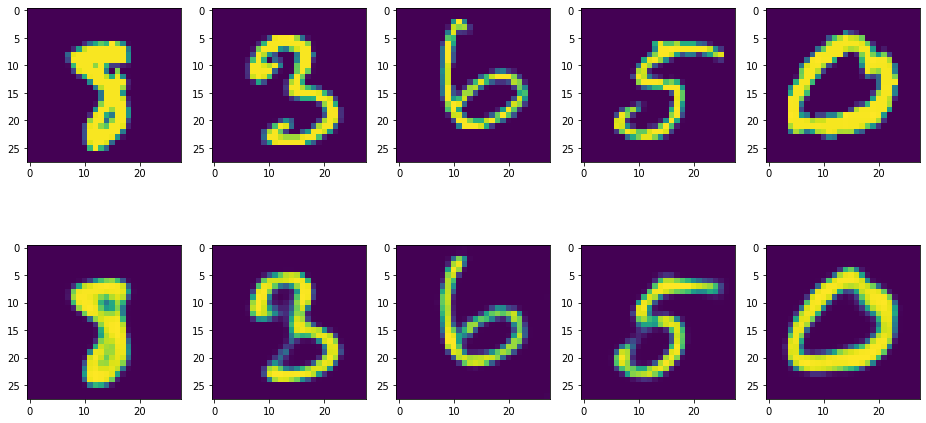

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(outputs[k,0,:,:].data.cpu()))
plt.show()

<br>
<br>
<br>
A présent on commence à explorer l'espace des codes : on va afficher des images de sorties correspondant à des codes aléatoires. Pour cela on construit des vecteurs aléatoires de la dimension du code puis on applique la partie décodage du réseau uniquement. On pourrait s'attendre à observer des images ressemblant à des images de chiffres ici ; cependant ce n'est pas le cas. On peut interpréter ceci en supposant que malgré la réduction de dimension opérée par le codage, les codes correspondant aux images de chiffres ne remplissent pas tout l'espace des codes.

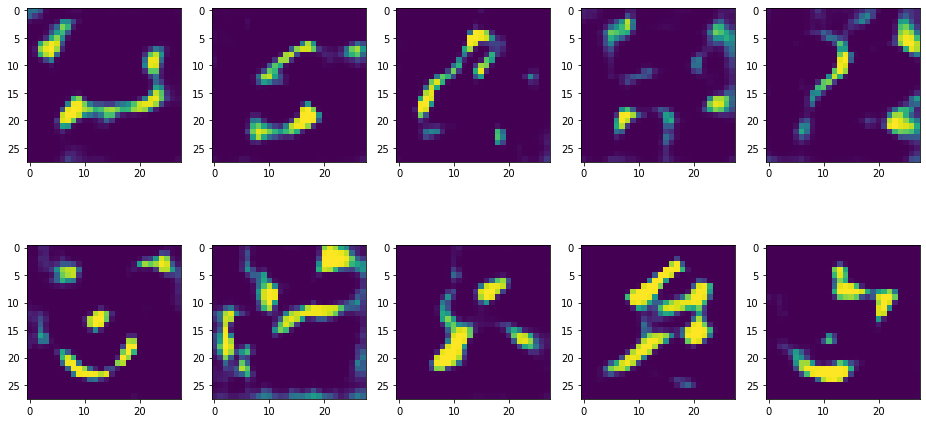

In [ ]:
code = torch.randn(10,dim_code,device=device)
out = model.fcd(code)
out = out.reshape(10,32,7,7)
out = model.decoder(out)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(out.data[k,0,:,:].cpu()))

<br>
<br>
<br>
A présent on va effectuer une moyenne dans l'espace des codes et observer l'image correspondante après décodage. On commence par sélectionner les images correspondant à des chiffres 3 et on applique à la main la partie encodage pour obtenir l'ensemble de leurs codes dans la variable code3

In [ ]:
images3 = images[labels==3,:,:,:]
n3 = images3.size(0)
out = model.encoder(images3)
out = out.reshape(out.size(0), -1)
code3 = model.fce(out)

Affichons les images décodées à la main à partir des codes (ceci n'est pas nécessaire pour la suite, juste un exercice)

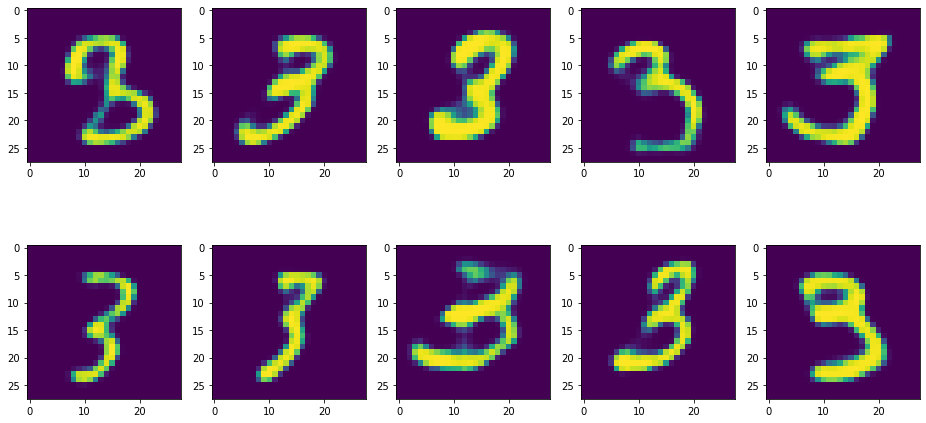

In [ ]:
out = model.fcd(code3)
out = out.reshape(n3,32,7,7)
out = model.decoder(out)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(min(10,len(code3))):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(out.data[k,0,:,:].cpu()))

<br>
<br>
<br>
On effectue à présent la moyenne dans l'espace des codes, on applique le décodage à la moyenne et on affiche l'image de sortie (à droite). On compare avec la moyenne des images dans l'espace d'origine (à gauche). On peut observer que l'image correspondant à la moyenne dans l'espace des codes est plus proche de l'idée intuitive d'un "3 moyen" ou "idéal".

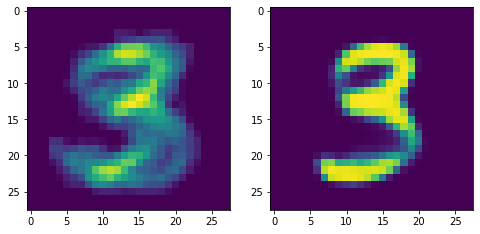

In [ ]:
code = code3.mean(dim=0).reshape(1,dim_code)
out = model.fcd(code)
out = out.reshape(1,32,7,7)
out = model.decoder(out)
mean3 = images3.mean(dim=0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.subplot(1,2,1)
plt.imshow(np.squeeze(mean3.data[0,:,:].cpu()))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()))
plt.show()

<br>
<br>
<br>
A présent on va effectuer une interpolation linéaire dans l''espace des codes entre deux codes correspondant à
des images des chiffres différents, et on va comparer avec l'interpolation dans l'espace des images (qui est une simple superposition pondérée des images). Ici encore on voit que l'interpolation dans l'espace des codes est plus proche de l'idée intuitive d'une transition progressive entre deux formes différentes de chiffre 3.

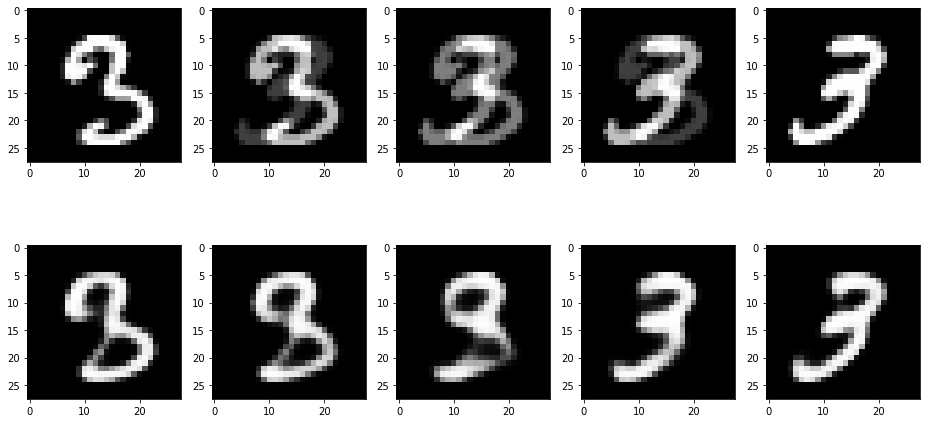

In [ ]:
k = 1
plt.rcParams['figure.figsize'] = [16, 8]
for p in np.linspace(0,1,5):
    image = (1-p)*images3.data[0,:]+p*images3.data[1,:]
    plt.subplot(2,5,k)
    plt.imshow(np.squeeze(image.data[0,:,:].cpu()), vmin=0, vmax=1, cmap="gray")
    code = (1-p)*code3.data[0,:]+p*code3.data[1,:]
    out = model.fcd(code)
    out = out.reshape(1,32,7,7)
    out = model.decoder(out)
    plt.subplot(2,5,k+5)
    plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()), vmin=0, vmax=1, cmap="gray")
    k += 1

<br>
<br>
<br>
Même expérience avec deux chiffres différents et plus d'étapes intermédiaires. On peut observer ici parfois que l'interpolation entre un chiffre 7 et un 2 dans l'espace des codes passe par une forme intermédiaire proche d'un autre chiffre.

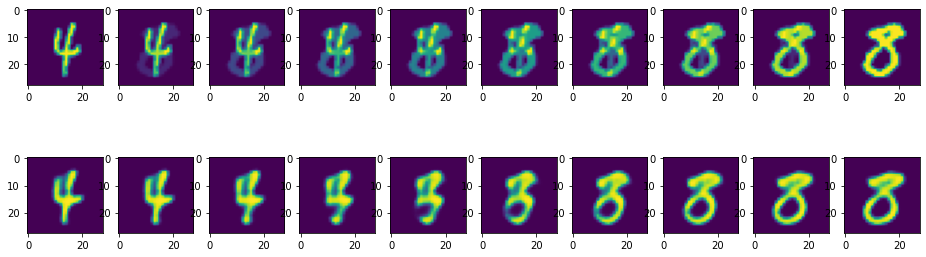

In [ ]:
k = 1
plt.rcParams['figure.figsize'] = [16, 5]
ind7, = np.where(labels.cpu().numpy()==4)
ind2, = np.where(labels.cpu().numpy()==8)
out = model.encoder(images[ind7[0]].unsqueeze(0))
out = out.reshape(out.size(0), -1)
code0 = model.fce(out)
out = model.encoder(images[ind2[2]].unsqueeze(0))
out = out.reshape(out.size(0), -1)
code1 = model.fce(out)
for p in np.linspace(0,1,10):
    image = (1-p)*images.data[ind7[0],:]+p*images.data[ind2[2],:]
    plt.subplot(2,10,k)
    plt.imshow(np.squeeze(image.data[0,:,:].cpu()));
    code = (1-p)*code0.data[0,:]+p*code1.data[0,:]
    out = model.fcd(code)
    out = out.reshape(1,32,7,7)
    out = model.decoder(out)
    plt.subplot(2,10,k+10)
    plt.imshow(np.squeeze(out.data[0,0,:,:].cpu()));
    k += 1

<br>
<br>
<br>

### Visualisation de l'espace des codes

Si la dimension de l'espace des codes est égale à 2 ou 3, on peut visualiser le nuage de points correspondant aux données.

*Attention : cette partie nécessite d'avoir relancé tout ce qui précède en fixant dim_code=3*

<IPython.core.display.Javascript object>


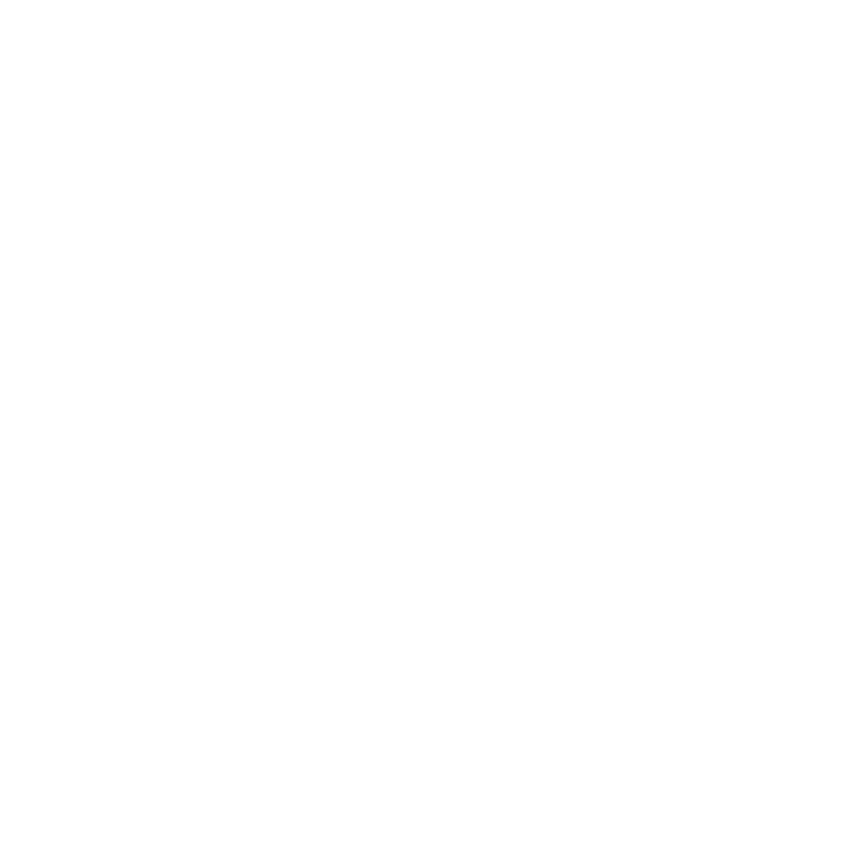

TypeError: text() takes from 5 to 6 positional arguments but 32 were given

In [ ]:
n = 1000

labels = train_dataset.targets[:n]
images = train_dataset.data[:n,None,::].float()

out = model.encoder(images)
out = out.reshape(out.size(0), -1)
codes = model.fce(out)
codes = codes - torch.min(codes)
codes = codes / torch.max(codes)

%matplotlib notebook
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
clr = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
       'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i in range(n):
    code = codes[i]
    l = labels[i].item()
    ax.text(*code, l, color=clr[l])
plt.tight_layout()
plt.show()

## Questions supplémentaires

tensor([7, 2, 1, 0, 4])


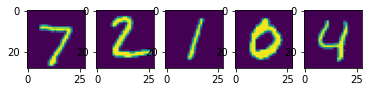

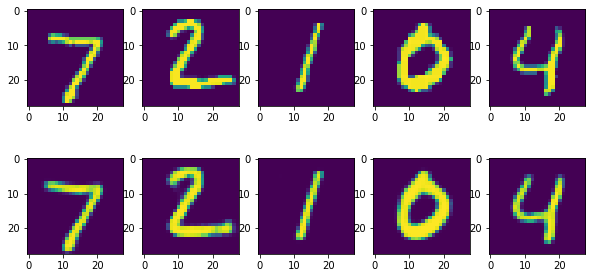

In [ ]:
# 1. appliquer le réseau entraîné à un batch d'images test et afficher les images
# d'entrée et de sortie

%matplotlib inline

labels = test_dataset.targets
print(labels[0:5])
images = test_dataset.data.float()/255
import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images[k,:,:])
plt.show()

images = images[:10,:,:][:,None,:,:]
images_sortie = model(images)

plt.rcParams['figure.figsize'] = [10, 5]
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(images_sortie[k,0,:,:].data.cpu()))
plt.show()

tensor([9, 2, 1, 1, 6])


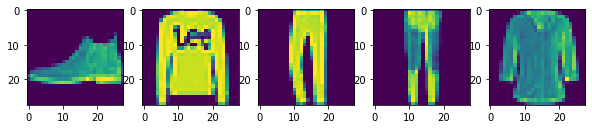

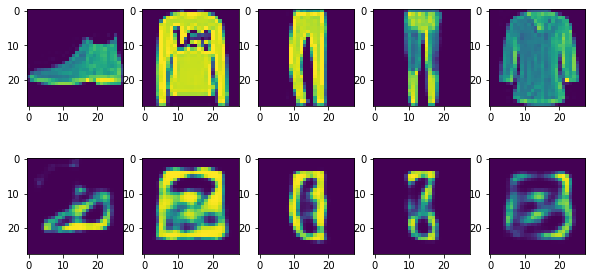

In [ ]:
# 2. appliquer le réseau entraîné à un batch d'images test du dataset FashionMNIST
# et afficher les images d'entrée et de sortie

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download = True
                                                )

labels = test_dataset.targets
print(labels[0:5])
images = test_dataset.data.float()/255
import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images[k,:,:])
plt.show()

images = images[:10,:,:][:,None,:,:]
images_sortie = model(images)

plt.rcParams['figure.figsize'] = [10, 5]
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(images_sortie[k,0,:,:].data.cpu()))
plt.show()

tensor([5, 0, 4, 1, 9])


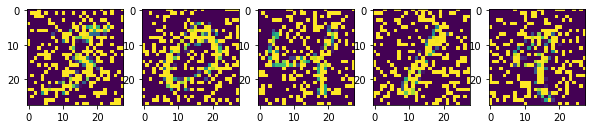

In [ ]:
# 3. Denoising auto-encoder :
# Ré-entraîner le réseau sur des versions bruitées des images des données train
# (avec bruit salt_and_pepper)

def gaussian_noise(images,sigma=.25):
    images_noisy = images.clone()
    rnd = torch.randn(images.shape, device=images.device)
    images_noisy += sigma * rnd
    images_noisy = images_noisy.clamp(0,1)
    return images_noisy

def salt_and_pepper(images,prob=.5):
    images_noisy = images.clone()
    rnd = torch.rand(images.shape)
    images_noisy[rnd<prob/2] = 0
    images_noisy[rnd>1-prob/2] = 1
    return images_noisy

def remove(images,prob=.5):
    images_alt = images.clone()
    images_alt[...,15:,:] = 0
    return images_alt

def identity(images):
    return images

alteration = salt_and_pepper


labels = train_dataset.targets
print(labels[0:5])
images = train_dataset.data.float()/255

images_bruitees = alteration(images)

import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images_bruitees[k,:,:])
plt.show()


In [ ]:
# Train the model
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        images_bruitees  = alteration(images)

        # Forward pass
        outputs = model(images_bruitees)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/600], Loss: 0.1403
Epoch [1/5], Step [200/600], Loss: 0.1275
Epoch [1/5], Step [300/600], Loss: 0.1259
Epoch [1/5], Step [400/600], Loss: 0.1187
Epoch [1/5], Step [500/600], Loss: 0.1202
Epoch [1/5], Step [600/600], Loss: 0.1129
Epoch [2/5], Step [100/600], Loss: 0.1160
Epoch [2/5], Step [200/600], Loss: 0.1146
Epoch [2/5], Step [300/600], Loss: 0.1168
Epoch [2/5], Step [400/600], Loss: 0.1192
Epoch [2/5], Step [500/600], Loss: 0.1130
Epoch [2/5], Step [600/600], Loss: 0.1087
Epoch [3/5], Step [100/600], Loss: 0.1100
Epoch [3/5], Step [200/600], Loss: 0.1091
Epoch [3/5], Step [300/600], Loss: 0.1148
Epoch [3/5], Step [400/600], Loss: 0.1131
Epoch [3/5], Step [500/600], Loss: 0.1164
Epoch [3/5], Step [600/600], Loss: 0.1130
Epoch [4/5], Step [100/600], Loss: 0.1122
Epoch [4/5], Step [200/600], Loss: 0.1104
Epoch [4/5], Step [300/600], Loss: 0.1106
Epoch [4/5], Step [400/600], Loss: 0.1124
Epoch [4/5], Step [500/600], Loss: 0.1079
Epoch [4/5],

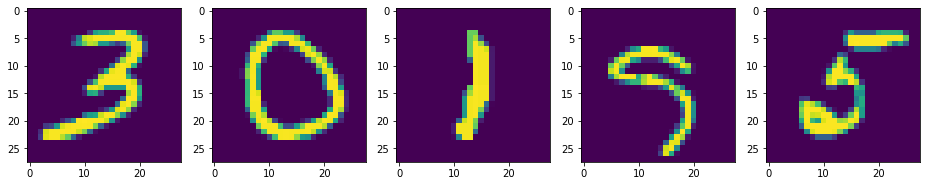

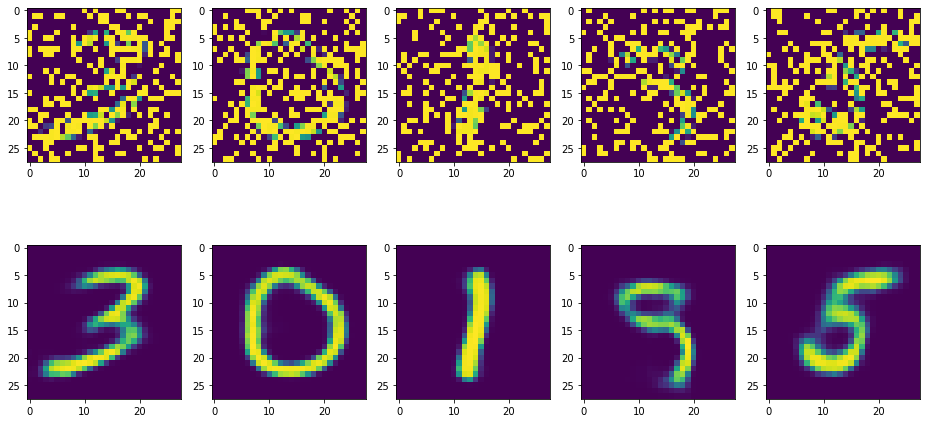

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
plt.show()
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images_bruitees[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(outputs[k,0,:,:].data.cpu()))
plt.show()

tensor([5, 0, 4, 1, 9])


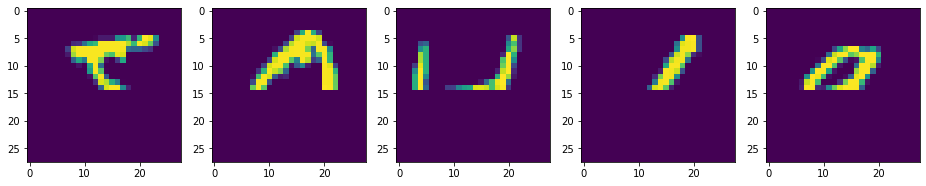

In [ ]:
# 4. Variation de l'auto-encodeur débruiteur :
# Ré-entraîner le réseau sur des versions tronquées des images des données train
# (obtenues avec l'altération "remove")

alteration = remove


labels = train_dataset.targets
print(labels[0:5])
images = train_dataset.data.float()/255

images_bruitees = alteration(images)

import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images_bruitees[k,:,:])
plt.show()

In [ ]:
# Train the model
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        images_bruitees  = alteration(images)

        # Forward pass
        outputs = model(images_bruitees)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/600], Loss: 0.1766
Epoch [1/5], Step [200/600], Loss: 0.1511
Epoch [1/5], Step [300/600], Loss: 0.1342
Epoch [1/5], Step [400/600], Loss: 0.1328
Epoch [1/5], Step [500/600], Loss: 0.1260
Epoch [1/5], Step [600/600], Loss: 0.1290
Epoch [2/5], Step [100/600], Loss: 0.1257
Epoch [2/5], Step [200/600], Loss: 0.1136
Epoch [2/5], Step [300/600], Loss: 0.1203
Epoch [2/5], Step [400/600], Loss: 0.1251
Epoch [2/5], Step [500/600], Loss: 0.1149
Epoch [2/5], Step [600/600], Loss: 0.1158
Epoch [3/5], Step [100/600], Loss: 0.1151
Epoch [3/5], Step [200/600], Loss: 0.1171
Epoch [3/5], Step [300/600], Loss: 0.1169
Epoch [3/5], Step [400/600], Loss: 0.1225
Epoch [3/5], Step [500/600], Loss: 0.1147
Epoch [3/5], Step [600/600], Loss: 0.1163
Epoch [4/5], Step [100/600], Loss: 0.1183
Epoch [4/5], Step [200/600], Loss: 0.1113
Epoch [4/5], Step [300/600], Loss: 0.1115
Epoch [4/5], Step [400/600], Loss: 0.1068
Epoch [4/5], Step [500/600], Loss: 0.1078
Epoch [4/5],

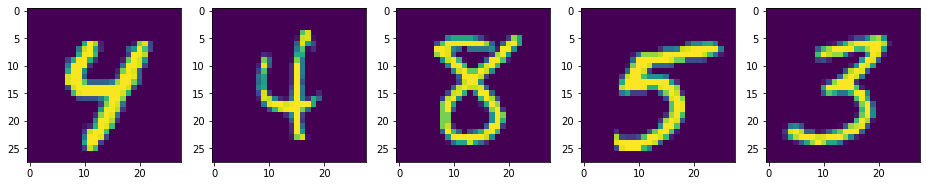

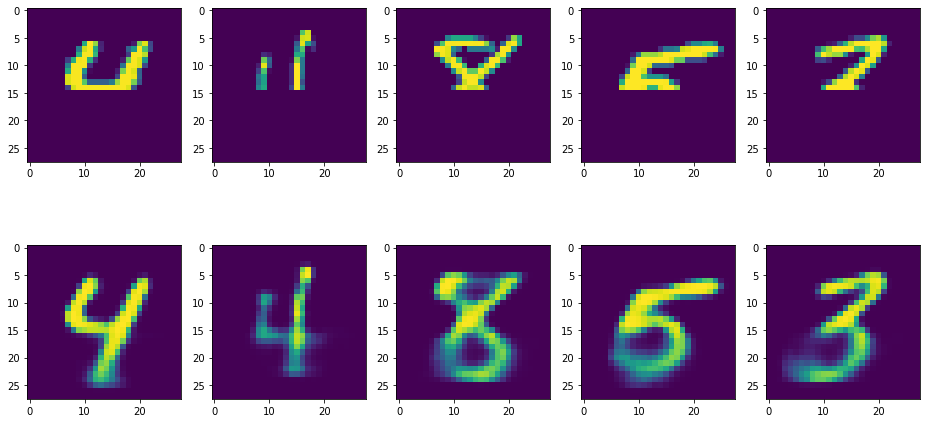

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(np.squeeze(images[k,0,:,:].cpu()))
plt.show()
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(images_bruitees[k,0,:,:].cpu()))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(outputs[k,0,:,:].data.cpu()))
plt.show()